In [1]:
# 인공신경망관련 패키지
from keras.callbacks import ModelCheckpoint
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten

# 회귀분석 관련 패키지
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error 
from xgboost import XGBRegressor


# 시각화 패키지
from matplotlib import pyplot as plt
import seaborn as sb

# 데이터 처리를 위한 패키지
import pandas as pd
import numpy as np
import math

# 다중공선성(multicollinearity) 처리를 위한VIF 확인 패키지
from statsmodels.stats.outliers_influence import variance_inflation_factor

import matplotlib
import matplotlib.pyplot as plt
# 한글 처리
from matplotlib import rc, font_manager
font_name = font_manager.FontProperties(fname='C:/Windows/Fonts/NanumGothicCoding.ttf').get_name()
rc('font',family=font_name)

# - 마이너스 사인 처리
matplotlib.rcParams['axes.unicode_minus'] = False

# DeprecationWarning경고 무시
# 향후 안쓰일 함수들을 이용해서 만들어져 있기 때문에 필요하다 없으면, 사방이 붉어진다.
import warnings 
warnings.filterwarnings('ignore')
warnings.filterwarnings('ignore', category=DeprecationWarning)

Using TensorFlow backend.
C:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
#########################################################################
# MAD 기반 예제코드
def mad_based_outlier(points, thresh=3.5):
    if len(points.shape) == 1:
        points = points[:,None]
    median = np.median(points, axis=0)
    diff = np.sum((points - median)**2, axis=-1)
    diff = np.sqrt(diff)
    med_abs_deviation = np.median(diff)
    modified_z_score = 0.6745 * diff / med_abs_deviation
    return modified_z_score > thresh 

# 출처: https://pythonanalysis.tistory.com/7 [Python 데이터 분석]
#########################################################################

# 소셜 데이터 처리를 위한 함수
# 1. 모든 소셜 데이터 column들의 첫번째는 : 날짜다.
# 2. 각 소셜데이터는 social_키워드.블로그/트위터/뉴스/총합 으로 되어 있다.
def changeColNames(d,before, after) : 
    # 컬럼이름 시리즈로 만들어 반환
    # 통합하기 쉽게, 모든 데이터들의 날짜컬럼 이름을 date로 통일
    new_col_names = ['date']
    new_col_names.extend(list(d.columns)[1:])
    d.columns = new_col_names
    return pd.Series(d.columns).apply(lambda x : x.replace(before,after))

#########################################################################
# modeling 함수로 만들어 처리하기
def linReg(df, item, cols_using):
    cols = cols_using
    X = df.loc[df['category']==item, cols]
    y = df.loc[df['category']==item,'qty']

    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=0)

    model = LinearRegression().fit(X_train, y_train)
  
    print('LinearRegression을 이용한 %s의 회귀분석 결과 :'%item)
    print('훈련세트점수 : {:.2f}'.format(model.score(X_train, y_train)))
    print('검증세트점수 : {:.2f}'.format(model.score(X_test, y_test)))

    
def ridgeReg(df, item, cols_using):
    cols = cols_using
    X = df.loc[df['category']==item,cols]
    y = df.loc[df['category']==item,'qty']

    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=0)

    ridge = Ridge(alpha=0.1, normalize=True, random_state=0, tol=0.001).fit(X_train, y_train)
    
    print('RidgeRegression을 이용한 %s의 회귀분석 결과 :'%item)
    print('훈련세트점수 : {:.2f}'.format(ridge.score(X_train, y_train)))
    print('검증세트점수 : {:.2f}'.format(ridge.score(X_test, y_test)))


def lassoReg(df, item, cols_using):
    cols = cols_using
    X = df.loc[df['category']==item,cols]
    y = df.loc[df['category']==item,'qty']

    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=0)

    lasso = Lasso(alpha=0.1, max_iter=1000).fit(X=X_train, y=y_train)
  
    print('LassoRegression을 이용한 %s의 회귀분석 결과 :'%item)
    print('훈련세트점수 : {:.2f}'.format(lasso.score(X_train, y_train)) )
    print('검증세트점수 : {:.2f}'.format(lasso.score(X_test, y_test)) )

    #사용한 특성수
    print('사용한 특성수 : {}'.format(np.sum(lasso.coef_ != 0)) )
#########################################################################

# 자료가 1일 1행이라는 전제하에
# df길이를 이용하여 날짜수를 계산, 이후 2016년 1월1일을 1번째주 1일이라 기준하에
# 몇번째 주인지 알려주는 컬럼 추가. 향후 주단위로 종합할때 스인다.
def addDayWeek(df):
    df_work = df.copy()
    df_work['day'] = pd.Series(range(1,df_work.shape[0]+1))
    df_work['week'] = df_work['day'].apply(lambda x : math.ceil(x/7))
    return df_work
#########################################################################
# 자료를 병합해주는 함수, 어떤 item인지 어느 컬럼을 기준으로 할지 받아서 병합
def mergeForAnalysis(df1, df2, df3, item, on_what='date'):
    merged_df = pd.merge(df1.loc[df1.category==item], df2, on=on_what, how='left')
    merged_df = pd.merge(merged_df, df3, on=on_what, how='left')
    return merged_df


#########################################################################
def lowVIF(df, n=7, cols_using =['temp', 'cloud', 'wind','humid', 'hpa', 'sun_time', 'lgt_time', 
       'SO2', 'CO', 'O3', 'NO2', 'PM10', 'PM25'] ):
    col_to_use = cols_using
    vif = pd.DataFrame()
    vif["VIF_Factor"] = [variance_inflation_factor(
        df[col_to_use].values, i) for i in range(df[col_to_use].shape[1])]
    vif["features"] = col_to_use
    vif.sort_values("VIF_Factor")
    lowest_vif = vif.sort_values("VIF_Factor")[:n].reset_index()
    lowest_vif.drop(columns='index', inplace=True)
    return lowest_vif

#########################################################################
# ols모델용 formula 생성
def formulaGen(target, ind_features):
    '''
    formulaGen(목표컬럼명,[변수컬럼명1, 변수컬럼명2,...])
    '''
    custom_formula = target + " ~ "
    for f in range(len(ind_features)):
        custom_formula += ind_features[f]
        if f!=(len(ind_features)-1):
            custom_formula += " + "
    return custom_formula


#########################################################################

In [3]:
# 데이터 불러오기 (전처리 된 GS, 랄라블라, 날씨)
gs = pd.read_csv('d:/project/contest/data/processed/p_gs.csv', parse_dates=['date'])
lv = pd.read_csv('d:/project/contest/data/processed/p_lavla.csv', parse_dates=['date'])
w = pd.read_csv('d:/project/contest/data/processed/p_wUVair_seoul.csv', parse_dates=['date'], index_col=0)
sns_all = pd.read_csv('d:/project/contest/data/processed/social_all.csv', parse_dates=['date'])

# GS/lv 서울시만
gs_seoul = gs.loc[gs.pvn_nm =='서울특별시']
lv_seoul = lv.loc[lv.pvn_nm =='서울특별시']
w_seoul = w.loc[w['loc']==108]

cols_to_keep = ['date','bor_nm','gender','age_cd','category','qty']

# 일일, 구단위, 상품별 판매량 종합
lv_grouped = lv_seoul[cols_to_keep].groupby(by=['date','bor_nm','category']).sum().reset_index()

# 일단위로 자료 종합(qty는 일일 합계)
day_lv_grouped = lv_grouped.groupby(by=['date','category']).sum().reset_index()

In [4]:
# '제모제'만 빼서 df생성
item = '제모제'
grouped_by = 'date'
day_lv_grouped_w_item = pd.merge(day_lv_grouped.loc[day_lv_grouped.category==item],w_seoul,on='date',how='left')
# day_gs_grouped_w_item.head(3)
day_lv_grouped_w_sns_item = pd.merge(day_lv_grouped_w_item, sns_all,on='date',how='left')

# 일단 uv = 자외선 지수는 결측치가 많아서 제외
selected_cols = ['date', 'category', 'qty', 'temp', 'rain', 'cloud', 'wind','humid', 'hpa',
                 'sun_time', 'lgt_time', 'snow',
                 'SO2', 'CO', 'O3', 'NO2', 'PM10', 'PM25',
                 'pm_blog', 'pm_twitter', 'pm_news', 'pm_total',
                 'health_blog', 'health_twitter', 'health_news', 'health_total',
                 'date_blog', 'date_twitter', 'date_news', 'date_total',
                 'br_blog', 'br_twitter', 'br_news', 'br_total',
                 'hobby_blog', 'hobby_twitter', 'hobby_news', 'hobby_total']
lv_day_w = day_lv_grouped_w_sns_item[selected_cols]

## 모든 변수 - 날씨 소셜 전부

In [ ]:
# train_data = lv_day_w.loc[lv_day_w.date.between('2016-01-01','2017-12-31')]
# test_data = lv_day_w.loc[lv_day_w.date.between('2018-01-01','2018-12-31')]

# # train_data.describe() # 731일
# # test_data.describe() # 365일

# # 3년치 데이터 분리 : 종속변수('qty': 판매량)와 독립변수(판매량 제외 나머지 전부)
# combined = lv_day_w.loc[:,'temp':]
# target = lv_day_w.loc[:,'qty']

##### 날씨 소셜 전부 사용할 시 : 폭망 

# 날씨만 

In [5]:
list_col = ['temp', 'rain', 'cloud', 'wind', 'humid','hpa', 'sun_time', 'lgt_time', 'snow',
              'SO2', 'CO', 'O3', 'NO2', 'PM10','PM25',]
lv_day_w = lv_day_w[['date','qty']+list_col].groupby('date').mean().reset_index()
# gs_week_w.tail(2)

train_data = lv_day_w.loc[lv_day_w.date.between('2016-01-01','2017-12-31')]
test_data = lv_day_w.loc[lv_day_w.date.between('2018-01-01','2018-12-31')]

# 3년치 데이터 분리 : 종속변수('qty': 판매량)와 독립변수(판매량 제외 나머지 전부)
combined = lv_day_w.loc[:,'temp':'PM25']
target = lv_day_w.loc[:,'qty']

In [6]:
def get_cols_with_no_nans(df,col_type):
    '''
    Arguments :
    df : The dataframe to process
    col_type : 
          num : to only get numerical columns with no nans
          no_num : to only get nun-numerical columns with no nans
          all : to get any columns with no nans    
    '''
    if (col_type == 'num'):
        predictors = df.select_dtypes(exclude=['object'])
    elif (col_type == 'no_num'):
        predictors = df.select_dtypes(include=['object'])
    elif (col_type == 'all'):
        predictors = df
    else :
        print('Error : choose a type (num, no_num, all)')
        return 0
    cols_with_no_nans = []
    for col in predictors.columns:
        if not df[col].isnull().any():
            cols_with_no_nans.append(col)
    return cols_with_no_nans

In [7]:
num_cols = get_cols_with_no_nans(combined , 'num')
cat_cols = get_cols_with_no_nans(combined , 'no_num')

print ('Number of numerical columns with no nan values :',len(num_cols))
print ('Number of nun-numerical columns with no nan values :',len(cat_cols))

Number of numerical columns with no nan values : 15
Number of nun-numerical columns with no nan values : 0


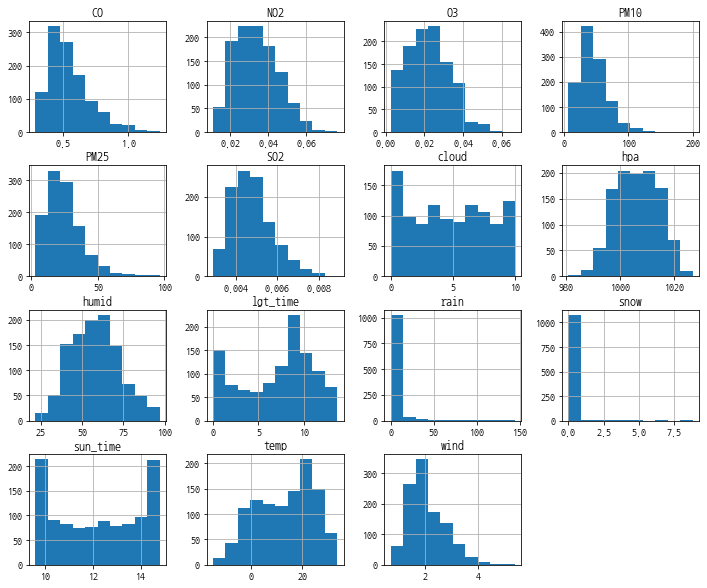

In [8]:
combined = combined[num_cols + cat_cols]
combined.hist(figsize = (12,10))
plt.show()

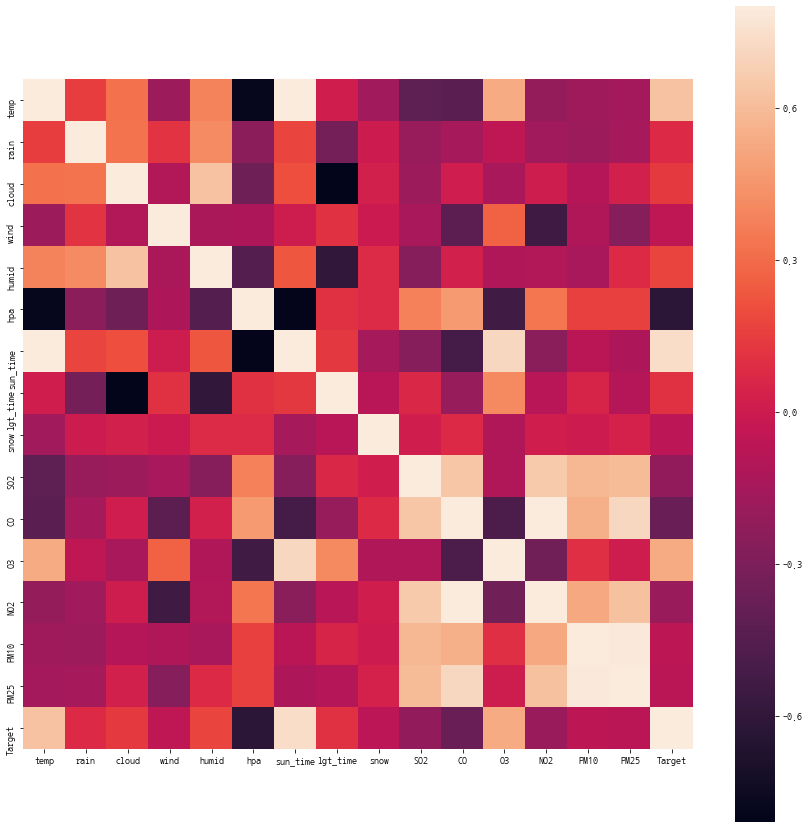

In [9]:
train_data = train_data[num_cols + cat_cols]
train_data['Target'] = target

C_mat = train_data.corr()
fig = plt.figure(figsize = (15,15))

sb.heatmap(C_mat, vmax = .8, square = True)
plt.show()

In [10]:
def oneHotEncode(df,colNames):
    for col in colNames:
        if( df[col].dtype == np.dtype('object')):
            dummies = pd.get_dummies(df[col],prefix=col)
            df = pd.concat([df,dummies],axis=1)

            #drop the encoded column
            df.drop([col],axis = 1 , inplace=True)
    return df
    

print('There were {} columns before encoding categorical features'.format(combined.shape[1]))
combined = oneHotEncode(combined, cat_cols)
print('There are {} columns after encoding categorical features'.format(combined.shape[1]))

There were 15 columns before encoding categorical features
There are 15 columns after encoding categorical features


In [11]:
cut_line = 732
def split_combined():
    global combined
    train = combined[:cut_line]
    test = combined[cut_line:]

    return train , test 
  
train, test = split_combined()

train.shape

(732, 15)

In [12]:
# 신경망 모델 생성
NN_model = Sequential()

# The Input Layer :
NN_model.add(Dense(128, kernel_initializer='normal',input_dim = train.shape[1], activation='relu'))

# The Hidden Layers :
NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))
NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))
NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))

# The Output Layer :
NN_model.add(Dense(1, kernel_initializer='normal',activation='linear'))

# Compile the network :
NN_model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mean_absolute_error'])
NN_model.summary()

W0717 15:31:41.552720  2168 deprecation_wrapper.py:119] From C:\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0717 15:31:41.567680  2168 deprecation_wrapper.py:119] From C:\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0717 15:31:41.570648  2168 deprecation_wrapper.py:119] From C:\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:4115: The name tf.random_normal is deprecated. Please use tf.random.normal instead.

W0717 15:31:41.623507  2168 deprecation_wrapper.py:119] From C:\Anaconda3\lib\site-packages\keras\optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 128)               2048      
_________________________________________________________________
dense_2 (Dense)              (None, 256)               33024     
_________________________________________________________________
dense_3 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_4 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 257       
Total params: 166,913
Trainable params: 166,913
Non-trainable params: 0
_________________________________________________________________


#### =========='xxxxxxxyyyyyzzzzz.hdf5'파일이 안주어지면 실행.(있으면 실행 필요없음)==========

In [13]:
checkpoint_name = 'LV-'+item+grouped_by+'-Weights-{epoch:03d}--{val_loss:.5f}.hdf5' 
checkpoint = ModelCheckpoint(checkpoint_name, monitor='val_loss', verbose = 1, save_best_only = True, mode ='auto')
callbacks_list = [checkpoint]

In [14]:
NN_model.fit(train, target[:cut_line], epochs=500, batch_size=32, validation_split = 0.2, callbacks=callbacks_list)

W0717 15:31:45.224441  2168 deprecation_wrapper.py:119] From C:\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.

W0717 15:31:45.337168  2168 deprecation_wrapper.py:119] From C:\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:973: The name tf.assign is deprecated. Please use tf.compat.v1.assign instead.



Train on 585 samples, validate on 147 samples
Epoch 1/500
585/585 [==============================] - 0s 536us/step - loss: 1381.0600 - mean_absolute_error: 1381.0600 - val_loss: 743.2563 - val_mean_absolute_error: 743.2563

Epoch 00001: val_loss improved from inf to 743.25632, saving model to LV-제모제date-Weights-001--743.25632.hdf5
Epoch 2/500
585/585 [==============================] - 0s 82us/step - loss: 1157.9562 - mean_absolute_error: 1157.9562 - val_loss: 394.9121 - val_mean_absolute_error: 394.9121

Epoch 00002: val_loss improved from 743.25632 to 394.91210, saving model to LV-제모제date-Weights-002--394.91210.hdf5
Epoch 3/500
585/585 [==============================] - 0s 82us/step - loss: 1153.7546 - mean_absolute_error: 1153.7546 - val_loss: 474.0967 - val_mean_absolute_error: 474.0967

Epoch 00003: val_loss did not improve from 394.91210
Epoch 4/500
585/585 [==============================] - 0s 85us/step - loss: 1134.6656 - mean_absolute_error: 1134.6656 - val_loss: 494.3597 - val


Epoch 00035: val_loss did not improve from 363.15626
Epoch 36/500
585/585 [==============================] - 0s 75us/step - loss: 634.1692 - mean_absolute_error: 634.1692 - val_loss: 498.6621 - val_mean_absolute_error: 498.6621

Epoch 00036: val_loss did not improve from 363.15626
Epoch 37/500
585/585 [==============================] - 0s 84us/step - loss: 622.8302 - mean_absolute_error: 622.8302 - val_loss: 567.3210 - val_mean_absolute_error: 567.3210

Epoch 00037: val_loss did not improve from 363.15626
Epoch 38/500
585/585 [==============================] - 0s 78us/step - loss: 645.7273 - mean_absolute_error: 645.7273 - val_loss: 566.3236 - val_mean_absolute_error: 566.3236

Epoch 00038: val_loss did not improve from 363.15626
Epoch 39/500
585/585 [==============================] - 0s 84us/step - loss: 624.5468 - mean_absolute_error: 624.5468 - val_loss: 678.3333 - val_mean_absolute_error: 678.3333

Epoch 00039: val_loss did not improve from 363.15626
Epoch 40/500
585/585 [========


Epoch 00071: val_loss did not improve from 363.15626
Epoch 72/500
585/585 [==============================] - 0s 82us/step - loss: 608.0129 - mean_absolute_error: 608.0129 - val_loss: 487.0289 - val_mean_absolute_error: 487.0289

Epoch 00072: val_loss did not improve from 363.15626
Epoch 73/500
585/585 [==============================] - 0s 80us/step - loss: 594.8534 - mean_absolute_error: 594.8534 - val_loss: 510.3065 - val_mean_absolute_error: 510.3065

Epoch 00073: val_loss did not improve from 363.15626
Epoch 74/500
585/585 [==============================] - 0s 80us/step - loss: 614.6878 - mean_absolute_error: 614.6878 - val_loss: 479.5396 - val_mean_absolute_error: 479.5396

Epoch 00074: val_loss did not improve from 363.15626
Epoch 75/500
585/585 [==============================] - 0s 78us/step - loss: 592.1517 - mean_absolute_error: 592.1517 - val_loss: 565.6775 - val_mean_absolute_error: 565.6775

Epoch 00075: val_loss did not improve from 363.15626
Epoch 76/500
585/585 [========


Epoch 00107: val_loss did not improve from 363.15626
Epoch 108/500
585/585 [==============================] - 0s 94us/step - loss: 577.5842 - mean_absolute_error: 577.5842 - val_loss: 572.7573 - val_mean_absolute_error: 572.7573

Epoch 00108: val_loss did not improve from 363.15626
Epoch 109/500
585/585 [==============================] - 0s 82us/step - loss: 562.6937 - mean_absolute_error: 562.6937 - val_loss: 405.4871 - val_mean_absolute_error: 405.4871

Epoch 00109: val_loss did not improve from 363.15626
Epoch 110/500
585/585 [==============================] - 0s 82us/step - loss: 573.3117 - mean_absolute_error: 573.3117 - val_loss: 515.4403 - val_mean_absolute_error: 515.4403

Epoch 00110: val_loss did not improve from 363.15626
Epoch 111/500
585/585 [==============================] - 0s 78us/step - loss: 567.0187 - mean_absolute_error: 567.0187 - val_loss: 419.4856 - val_mean_absolute_error: 419.4856

Epoch 00111: val_loss did not improve from 363.15626
Epoch 112/500
585/585 [===

585/585 [==============================] - 0s 87us/step - loss: 528.9497 - mean_absolute_error: 528.9497 - val_loss: 371.0129 - val_mean_absolute_error: 371.0129

Epoch 00143: val_loss did not improve from 362.76842
Epoch 144/500
585/585 [==============================] - 0s 91us/step - loss: 551.4353 - mean_absolute_error: 551.4353 - val_loss: 392.8184 - val_mean_absolute_error: 392.8184

Epoch 00144: val_loss did not improve from 362.76842
Epoch 145/500
585/585 [==============================] - 0s 106us/step - loss: 544.3045 - mean_absolute_error: 544.3045 - val_loss: 396.4347 - val_mean_absolute_error: 396.4347

Epoch 00145: val_loss did not improve from 362.76842
Epoch 146/500
585/585 [==============================] - 0s 97us/step - loss: 538.2986 - mean_absolute_error: 538.2986 - val_loss: 370.3602 - val_mean_absolute_error: 370.3602

Epoch 00146: val_loss did not improve from 362.76842
Epoch 147/500
585/585 [==============================] - 0s 95us/step - loss: 548.3530 - mean

585/585 [==============================] - 0s 100us/step - loss: 524.6518 - mean_absolute_error: 524.6518 - val_loss: 387.1217 - val_mean_absolute_error: 387.1217

Epoch 00178: val_loss did not improve from 345.31063
Epoch 179/500
585/585 [==============================] - 0s 102us/step - loss: 520.1731 - mean_absolute_error: 520.1731 - val_loss: 399.1728 - val_mean_absolute_error: 399.1728

Epoch 00179: val_loss did not improve from 345.31063
Epoch 180/500
585/585 [==============================] - 0s 109us/step - loss: 518.1857 - mean_absolute_error: 518.1857 - val_loss: 407.6612 - val_mean_absolute_error: 407.6612

Epoch 00180: val_loss did not improve from 345.31063
Epoch 181/500
585/585 [==============================] - 0s 138us/step - loss: 516.7146 - mean_absolute_error: 516.7146 - val_loss: 440.6061 - val_mean_absolute_error: 440.6061

Epoch 00181: val_loss did not improve from 345.31063
Epoch 182/500
585/585 [==============================] - 0s 111us/step - loss: 505.5227 - 

Epoch 213/500
585/585 [==============================] - 0s 112us/step - loss: 494.3673 - mean_absolute_error: 494.3673 - val_loss: 444.5335 - val_mean_absolute_error: 444.5335

Epoch 00213: val_loss did not improve from 336.55710
Epoch 214/500
585/585 [==============================] - 0s 125us/step - loss: 502.7135 - mean_absolute_error: 502.7135 - val_loss: 410.4031 - val_mean_absolute_error: 410.4031

Epoch 00214: val_loss did not improve from 336.55710
Epoch 215/500
585/585 [==============================] - 0s 118us/step - loss: 539.5715 - mean_absolute_error: 539.5715 - val_loss: 355.1382 - val_mean_absolute_error: 355.1382

Epoch 00215: val_loss did not improve from 336.55710
Epoch 216/500
585/585 [==============================] - 0s 109us/step - loss: 532.2567 - mean_absolute_error: 532.2567 - val_loss: 479.8892 - val_mean_absolute_error: 479.8892

Epoch 00216: val_loss did not improve from 336.55710
Epoch 217/500
585/585 [==============================] - 0s 113us/step - los

585/585 [==============================] - 0s 111us/step - loss: 483.9690 - mean_absolute_error: 483.9690 - val_loss: 452.2603 - val_mean_absolute_error: 452.2603

Epoch 00248: val_loss did not improve from 318.41999
Epoch 249/500
585/585 [==============================] - 0s 114us/step - loss: 500.7951 - mean_absolute_error: 500.7951 - val_loss: 352.9095 - val_mean_absolute_error: 352.9095

Epoch 00249: val_loss did not improve from 318.41999
Epoch 250/500
585/585 [==============================] - 0s 109us/step - loss: 483.1254 - mean_absolute_error: 483.1254 - val_loss: 484.6775 - val_mean_absolute_error: 484.6775

Epoch 00250: val_loss did not improve from 318.41999
Epoch 251/500
585/585 [==============================] - 0s 113us/step - loss: 516.4101 - mean_absolute_error: 516.4101 - val_loss: 380.4426 - val_mean_absolute_error: 380.4426

Epoch 00251: val_loss did not improve from 318.41999
Epoch 252/500
585/585 [==============================] - 0s 118us/step - loss: 485.9690 - 


Epoch 00283: val_loss did not improve from 318.41999
Epoch 284/500
585/585 [==============================] - 0s 121us/step - loss: 474.8912 - mean_absolute_error: 474.8912 - val_loss: 357.8080 - val_mean_absolute_error: 357.8080

Epoch 00284: val_loss did not improve from 318.41999
Epoch 285/500
585/585 [==============================] - 0s 138us/step - loss: 481.4701 - mean_absolute_error: 481.4701 - val_loss: 376.4402 - val_mean_absolute_error: 376.4402

Epoch 00285: val_loss did not improve from 318.41999
Epoch 286/500
585/585 [==============================] - 0s 131us/step - loss: 481.2776 - mean_absolute_error: 481.2776 - val_loss: 447.0854 - val_mean_absolute_error: 447.0854

Epoch 00286: val_loss did not improve from 318.41999
Epoch 287/500
585/585 [==============================] - 0s 131us/step - loss: 496.3276 - mean_absolute_error: 496.3276 - val_loss: 366.0767 - val_mean_absolute_error: 366.0767

Epoch 00287: val_loss did not improve from 318.41999
Epoch 288/500
585/585 

585/585 [==============================] - 0s 138us/step - loss: 481.2717 - mean_absolute_error: 481.2717 - val_loss: 362.3553 - val_mean_absolute_error: 362.3553

Epoch 00319: val_loss did not improve from 318.41999
Epoch 320/500
585/585 [==============================] - 0s 131us/step - loss: 469.3862 - mean_absolute_error: 469.3862 - val_loss: 356.0824 - val_mean_absolute_error: 356.0824

Epoch 00320: val_loss did not improve from 318.41999
Epoch 321/500
585/585 [==============================] - 0s 133us/step - loss: 461.9766 - mean_absolute_error: 461.9766 - val_loss: 375.4621 - val_mean_absolute_error: 375.4621

Epoch 00321: val_loss did not improve from 318.41999
Epoch 322/500
585/585 [==============================] - 0s 123us/step - loss: 474.4597 - mean_absolute_error: 474.4597 - val_loss: 365.6379 - val_mean_absolute_error: 365.6379

Epoch 00322: val_loss did not improve from 318.41999
Epoch 323/500
585/585 [==============================] - 0s 127us/step - loss: 480.7261 - 


Epoch 00354: val_loss did not improve from 318.41999
Epoch 355/500
585/585 [==============================] - ETA: 0s - loss: 477.7936 - mean_absolute_error: 477.793 - 0s 128us/step - loss: 486.8644 - mean_absolute_error: 486.8644 - val_loss: 391.1698 - val_mean_absolute_error: 391.1698

Epoch 00355: val_loss did not improve from 318.41999
Epoch 356/500
585/585 [==============================] - 0s 131us/step - loss: 475.2023 - mean_absolute_error: 475.2023 - val_loss: 391.7176 - val_mean_absolute_error: 391.7176

Epoch 00356: val_loss did not improve from 318.41999
Epoch 357/500
585/585 [==============================] - 0s 123us/step - loss: 466.5345 - mean_absolute_error: 466.5345 - val_loss: 386.9029 - val_mean_absolute_error: 386.9029

Epoch 00357: val_loss did not improve from 318.41999
Epoch 358/500
585/585 [==============================] - 0s 126us/step - loss: 468.1157 - mean_absolute_error: 468.1157 - val_loss: 406.0230 - val_mean_absolute_error: 406.0230

Epoch 00358: val_

585/585 [==============================] - 0s 123us/step - loss: 486.7685 - mean_absolute_error: 486.7685 - val_loss: 399.8715 - val_mean_absolute_error: 399.8715

Epoch 00390: val_loss did not improve from 318.41999
Epoch 391/500
585/585 [==============================] - 0s 133us/step - loss: 469.9518 - mean_absolute_error: 469.9518 - val_loss: 364.6448 - val_mean_absolute_error: 364.6448

Epoch 00391: val_loss did not improve from 318.41999
Epoch 392/500
585/585 [==============================] - 0s 138us/step - loss: 476.1462 - mean_absolute_error: 476.1462 - val_loss: 336.0163 - val_mean_absolute_error: 336.0163

Epoch 00392: val_loss did not improve from 318.41999
Epoch 393/500
585/585 [==============================] - 0s 135us/step - loss: 483.6805 - mean_absolute_error: 483.6805 - val_loss: 368.1159 - val_mean_absolute_error: 368.1159

Epoch 00393: val_loss did not improve from 318.41999
Epoch 394/500
585/585 [==============================] - 0s 137us/step - loss: 458.8026 - 


Epoch 00425: val_loss did not improve from 318.41999
Epoch 426/500
585/585 [==============================] - 0s 148us/step - loss: 453.4940 - mean_absolute_error: 453.4940 - val_loss: 363.6331 - val_mean_absolute_error: 363.6331

Epoch 00426: val_loss did not improve from 318.41999
Epoch 427/500
585/585 [==============================] - 0s 134us/step - loss: 464.2045 - mean_absolute_error: 464.2045 - val_loss: 399.8311 - val_mean_absolute_error: 399.8311

Epoch 00427: val_loss did not improve from 318.41999
Epoch 428/500
585/585 [==============================] - 0s 137us/step - loss: 489.2628 - mean_absolute_error: 489.2628 - val_loss: 381.7461 - val_mean_absolute_error: 381.7461

Epoch 00428: val_loss did not improve from 318.41999
Epoch 429/500
585/585 [==============================] - 0s 132us/step - loss: 448.5524 - mean_absolute_error: 448.5524 - val_loss: 381.5557 - val_mean_absolute_error: 381.5557

Epoch 00429: val_loss did not improve from 318.41999
Epoch 430/500
585/585 

585/585 [==============================] - 0s 136us/step - loss: 478.3493 - mean_absolute_error: 478.3493 - val_loss: 381.0288 - val_mean_absolute_error: 381.0288

Epoch 00461: val_loss did not improve from 318.41999
Epoch 462/500
585/585 [==============================] - 0s 131us/step - loss: 444.2680 - mean_absolute_error: 444.2680 - val_loss: 400.7813 - val_mean_absolute_error: 400.7813

Epoch 00462: val_loss did not improve from 318.41999
Epoch 463/500
585/585 [==============================] - 0s 147us/step - loss: 453.0508 - mean_absolute_error: 453.0508 - val_loss: 342.6316 - val_mean_absolute_error: 342.6316

Epoch 00463: val_loss did not improve from 318.41999
Epoch 464/500
585/585 [==============================] - 0s 142us/step - loss: 445.3256 - mean_absolute_error: 445.3256 - val_loss: 344.5046 - val_mean_absolute_error: 344.5046

Epoch 00464: val_loss did not improve from 318.41999
Epoch 465/500
585/585 [==============================] - 0s 165us/step - loss: 448.6355 - 


Epoch 00496: val_loss did not improve from 318.41999
Epoch 497/500
585/585 [==============================] - 0s 140us/step - loss: 435.7737 - mean_absolute_error: 435.7737 - val_loss: 396.3508 - val_mean_absolute_error: 396.3508

Epoch 00497: val_loss did not improve from 318.41999
Epoch 498/500
585/585 [==============================] - 0s 155us/step - loss: 430.0769 - mean_absolute_error: 430.0769 - val_loss: 366.5281 - val_mean_absolute_error: 366.5281

Epoch 00498: val_loss did not improve from 318.41999
Epoch 499/500
585/585 [==============================] - 0s 140us/step - loss: 454.8053 - mean_absolute_error: 454.8053 - val_loss: 407.1089 - val_mean_absolute_error: 407.1089

Epoch 00499: val_loss did not improve from 318.41999
Epoch 500/500
585/585 [==============================] - 0s 143us/step - loss: 451.9586 - mean_absolute_error: 451.9586 - val_loss: 371.7935 - val_mean_absolute_error: 371.7935

Epoch 00500: val_loss did not improve from 318.41999


#### ====================================================================================================

In [15]:
# Load wights file of the best model :
wights_file = 'LV-제모제date-Weights-228--318.41999.hdf5' # choose the best checkpoint 
NN_model.load_weights(wights_file) # load it
NN_model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mean_absolute_error'])

In [16]:
train_X, val_X, train_y, val_y = train_test_split(train, target[:cut_line], test_size = 0.25, random_state = 14)

In [17]:
model = RandomForestRegressor()
model.fit(train_X,train_y)

# Get the mean absolute error on the validation data
RFpredicted = model.predict(val_X)
MAE = mean_absolute_error(val_y , RFpredicted)
print('Random forest validation MAE = ', MAE)
# print('훈련세트점수 : {:.2f}'.format(model.score(train_X, train_y)))
# print('검증세트점수 : {:.2f}'.format(model.score(val_X, val_y)))

Random forest validation MAE =  545.5551912568307


In [18]:
XGBModel = XGBRegressor()
XGBModel.fit(train_X,train_y , verbose=False)

# Get the mean absolute error on the validation data :
XGBpredictions = XGBModel.predict(val_X)
MAE = mean_absolute_error(val_y , XGBpredictions)
print('XGBoost validation MAE = ',MAE)
# print('훈련세트점수 : {:.2f}'.format(XGBModel.score(train_X, train_y)))
# print('검증세트점수 : {:.2f}'.format(XGBModel.score(val_X, val_y)))

[15:32:41] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
XGBoost validation MAE =  524.9728807960051


In [19]:
combined = lv_day_w.loc[:,'temp':]
# combined = lv_day_w.loc[:,'temp':'PM25']
target = lv_day_w.loc[:,'qty']
RFpredicted = model.predict(combined)
XGBpredictions = XGBModel.predict(combined)
predictions = NN_model.predict(combined)

result_df = pd.DataFrame()
result_df['date'] = lv_day_w['date']
result_df['qty'] = lv_day_w.loc[:,'qty']
print("keras 신경망 predictions",predictions.shape)
result_df['keras_qty'] = predictions
print("randomforest 예상",RFpredicted.shape)
result_df['rf_qty'] = RFpredicted
print("XGBpredictions",XGBpredictions.shape)
result_df['xgb_qty'] = XGBpredictions

keras 신경망 predictions (1094, 1)
randomforest 예상 (1094,)
XGBpredictions (1094,)


In [20]:
df_graph = result_df.loc[:,['date','keras_qty','rf_qty','xgb_qty','qty']]
df_graph['date'] = pd.to_datetime(df_graph['date'])

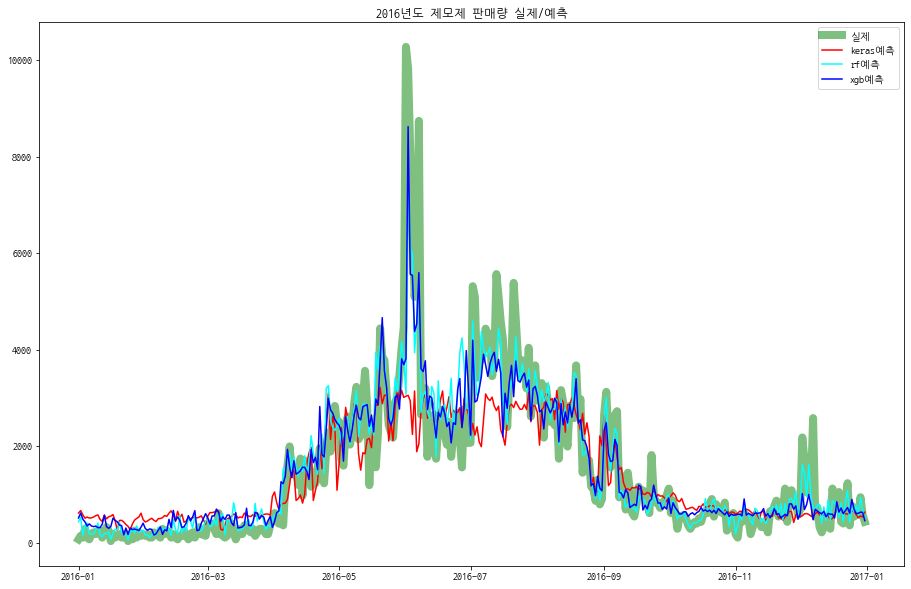

In [26]:
# 2016
df_graph = result_df.loc[result_df.date.between('2016-01-01','2016-12-31')]
plt.figure(figsize=(15.5, 10))
plt.plot(df_graph.date,df_graph.qty, ls='-', label='실제', color='green', alpha=0.5, lw=8)
plt.plot(df_graph.date,df_graph.keras_qty, ls='-', label='keras예측', color='r')
plt.plot(df_graph.date,df_graph.rf_qty, ls='-', label='rf예측', color='cyan')
plt.plot(df_graph.date,df_graph.xgb_qty, ls='-', label='xgb예측', color='b')
plt.legend()
plt.title('{}년도 {} 판매량 실제/예측'.format( '2016',item ))
plt.show()

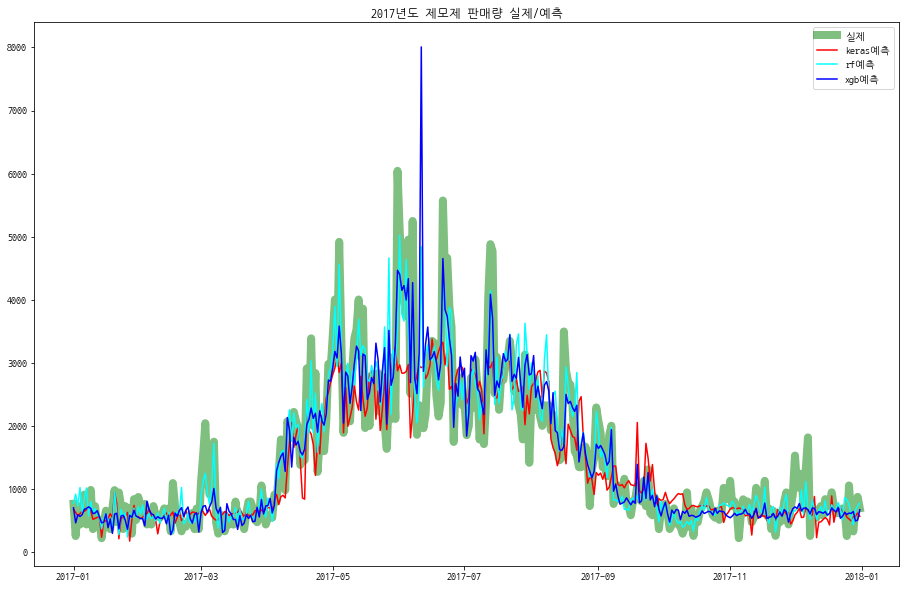

In [27]:
# 2017
df_graph = result_df.loc[result_df.date.between('2017-01-01','2017-12-31')]
plt.figure(figsize=(15.5, 10))
plt.plot(df_graph.date,df_graph.qty, ls='-', label='실제', color='green', alpha=0.5, lw=8)
plt.plot(df_graph.date,df_graph.keras_qty, ls='-', label='keras예측', color='r')
plt.plot(df_graph.date,df_graph.rf_qty, ls='-', label='rf예측', color='cyan')
plt.plot(df_graph.date,df_graph.xgb_qty, ls='-', label='xgb예측', color='b')
plt.title('{}년도 {} 판매량 실제/예측'.format( '2017',item ))
plt.legend()
plt.show()

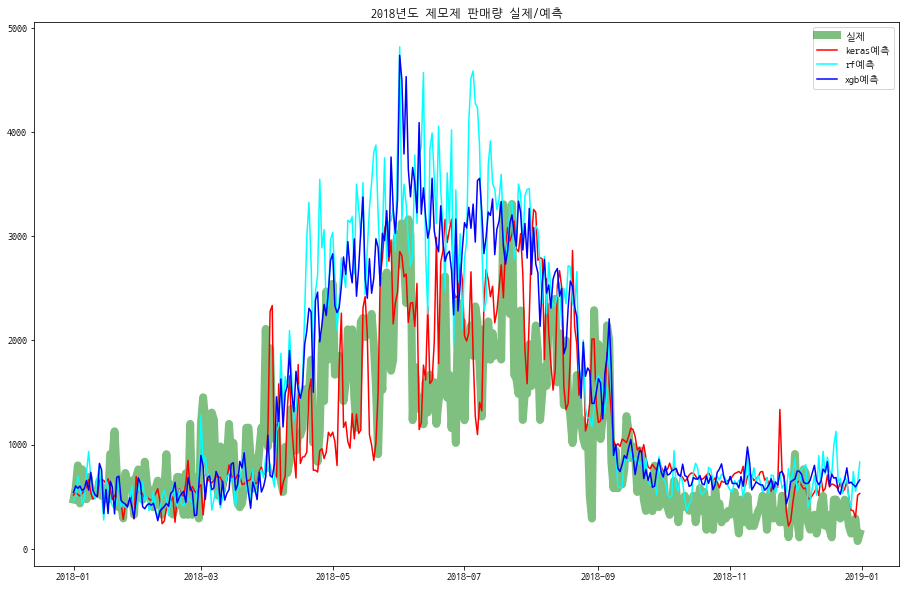

In [28]:
# 2018
df_graph = result_df.loc[result_df.date.between('2018-01-01','2018-12-31')]
plt.figure(figsize=(15.5, 10))
plt.plot(df_graph.date,df_graph.qty, ls='-', label='실제', color='green', alpha=0.5, lw=8)
plt.plot(df_graph.date,df_graph.keras_qty, ls='-', label='keras예측', color='r')
plt.plot(df_graph.date,df_graph.rf_qty, ls='-', label='rf예측', color='cyan')
plt.plot(df_graph.date,df_graph.xgb_qty, ls='-', label='xgb예측', color='b')
plt.title('{}년도 {} 판매량 실제/예측'.format( '2018',item ))
plt.legend()
plt.show()

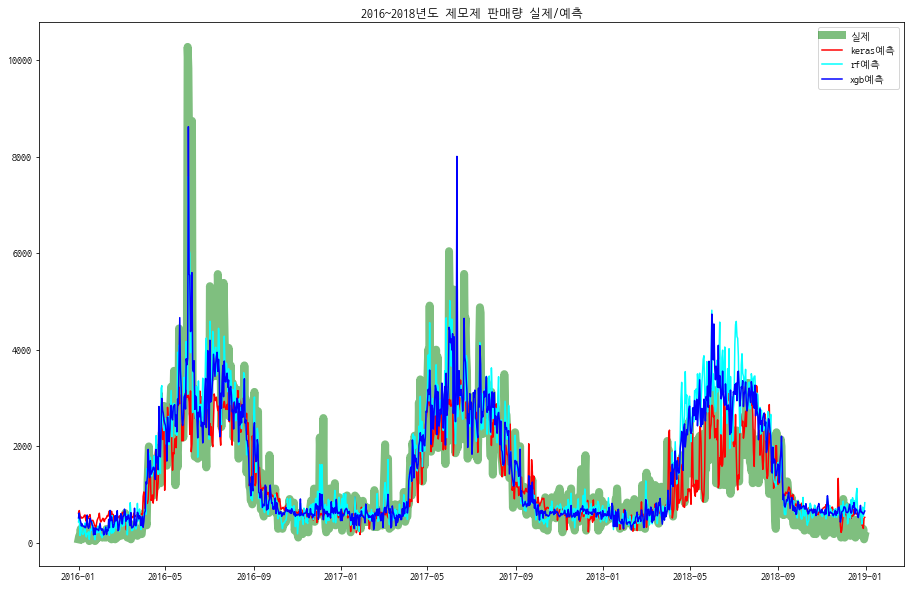

In [29]:
# 2016~2018
plt.figure(figsize=(15.5, 10))
plt.plot(result_df.date,result_df.qty, ls='-', label='실제', color='green', alpha=0.5, lw=8)
plt.plot(result_df.date,result_df.keras_qty, ls='-', label='keras예측', color='r')
plt.plot(result_df.date,result_df.rf_qty, ls='-', label='rf예측', color='cyan')
plt.plot(result_df.date,result_df.xgb_qty, ls='-', label='xgb예측', color='b')
plt.title('{}년도 {} 판매량 실제/예측'.format( '2016~2018',item ))
plt.legend()
plt.show()

In [30]:
orginal_mean = np.mean(result_df.qty)
result_df['qtyMinusMean'] = (result_df.qty - orginal_mean )
result_df['qtyMinusMeanSquared'] = (result_df.qty - orginal_mean )**2

result_df['kerasMiunsMeanSquared'] = (result_df.keras_qty - orginal_mean)**2
result_df['rfMiunsMeanSquared'] = (result_df.rf_qty - orginal_mean)**2
result_df['xgbMiunsMeanSquared'] = (result_df.xgb_qty - orginal_mean)**2

print('kreas R-sq',(sum(result_df['kerasMiunsMeanSquared']) / sum(result_df['qtyMinusMeanSquared'])))
print('rf R-sq',(sum(result_df['rfMiunsMeanSquared']) / sum(result_df['qtyMinusMeanSquared'])))
print('xgb R-sq',(sum(result_df['xgbMiunsMeanSquared']) / sum(result_df['qtyMinusMeanSquared'])))

kreas R-sq 0.568732308749456
rf R-sq 1.0394101919668164
xgb R-sq 0.9503345713119912


In [31]:
path = 'D:/project/contest/data/result/'
result_df.to_csv(path+item+'_'+grouped_by+'_predict.csv', encoding='utf-8', index=False)